# API calling

We import all the libraries we will need during the API calls.

In [171]:
import requests
import json
from dotenv import load_dotenv
import pandas as pd
from functools import reduce
import operator
import geopandas as gpd
from pymongo import MongoClient,GEOSPHERE
import shapely.geometry
import geopandas as gpd
from cartoframes.viz import Map, Layer, popup_element
import src.funciones as f

ModuleNotFoundError: No module named 'src'

## Our company:

In [160]:
company = "Bayard Building, Bleecker Street, New York, NY 10012, United States of America"

In [159]:
livestream = pd.read_csv('comps.csv', encoding = 'ISO - 8859-1')
livestream

,city,country_code,latitude,longitude,name,category_code,number_of_employees,founded_year
0,New York,USA,40.726155,-73.995625,Livestream,games_video,120,2007
1,New York,USA,40.722655,-73.998730,Pando Networks,games_video,23,2004
2,New York,USA,37.090240,-95.712891,SpiralFrog,games_video,15,2004
3,New York,USA,40.717248,-74.002662,Boonty,games_video,150,2001
4,New York,USA,40.739930,-73.993049,Cellufun,games_video,30,2005
5,New York,USA,40.752672,-73.975930,Major League Gaming,games_video,45,2002
6,New York,USA,40.743877,-73.986180,Saavn,games_video,25,2006
7,New York,USA,40.743877,-73.986180,[212]Media,games_video,75,2004
8,New York,USA,40.756054,-73.986951,Yoostar,games_video,40,2007
9,Los Angeles,USA,34.052187,-118.243425,Yoostar,games_video,40,2007


In [161]:
donde = input
def geocode(address):
    """
    Introduciendo un dirección se obtiene las coordenadas
    """
    data = requests.get(f"https://geocode.xyz/{address}?json=1").json()
    try:
        return {
            "type":"Point",
            "coordinates":[float(data["latt"]),float(data["longt"])]}
    except:
        return data  

In [162]:
geocode(company)

{'type': 'Point', 'coordinates': [40.72523, -73.99221]}

We connect to our database in MongoDB:

In [35]:
from pymongo import MongoClient
conn = MongoClient("localhost:27017")
db = conn.get_database("ironhack")

In [40]:
from pymongo import GEOSPHERE

In [2]:
load_dotenv()

True

## FOURSQUARE

Once we have selected an ideal office which meets our needs, we will check through the API of Foursquare the following employee requirements:
- Designers like to go to design talks and share knowledge. There must be some nearby companies that also do design.
- 30% of the company staff have at least 1 child - nearby nurseries.
- Executives like Starbucks A LOT. Ensure there's a starbucks not too far.
- Account managers need to travel a lot - nearby airport/helipad.
- Everyone in the company is between 25 and 40, give them some place to go party.
- The office dog—"Dobby" needs a hairdresser every month. Ensure there's one not too far away.

##  Airport 

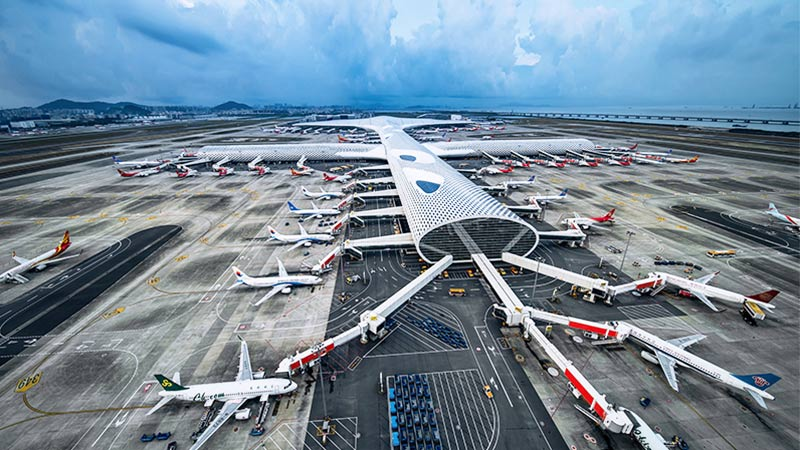

In [127]:
url = 'https://api.foursquare.com/v2/venues/explore'
tok1 = os.getenv("tok1")
tok2 = os.getenv("tok2")
params = {"client_id" : tok1,
              "client_secret" : tok2,
              "v": "20180323",
              "ll": f"40.72523, -73.99221",
              "query": "Airport",
              "limit": 10,
              "radius": 5000
             }

In [130]:
resp = requests.get(url=url, params=params)
airpdata = json.loads(resp.text)

In [132]:
airpdata.keys()

dict_keys(['meta', 'response'])

In [133]:
decoding_data = airpdata.get("response")

In [134]:
decoded = decoding_data.get("groups")[0]

In [135]:
airp = decoded.get("items")

In [136]:
mapan_nombre = ["venue","name"]
mn_latitud = ["venue","location","lat"]
mn_longitud = ["venue","location","lng"]

In [138]:
print(getFromDict(airp[0],mapani_nombre))
print(getFromDict(airp[0],mapani_latitud))
print(getFromDict(airp[0],mapani_longitud))

PH Helipad
40.73291778564453
-73.99546813964844


In [139]:
airports = []
for dic in airp:
    ai = {}
    ai["name"] = getFromDict(dic,mapan_nombre)
    ai["latitud"] = getFromDict(dic,mn_latitud)
    ai["longitud"] = getFromDict(dic,mn_longitud)
    airports.append(ai)

In [140]:
airports[0]

{'name': 'PH Helipad',
 'latitud': 40.73291778564453,
 'longitud': -73.99546813964844}

In [141]:
df_air = pd.DataFrame(airports)
df_air.head()

,name,latitud,longitud
0,PH Helipad,40.732918,-73.995468
1,Corporate Express Travel,40.722429,-74.002404
2,Atlantic Aviation,40.744048,-73.973925
3,Priority One Jets,40.709288,-74.006822
4,British Airways Concorde (G-BOAD),40.765299,-74.001889


In [142]:
gdf1 = gpd.GeoDataFrame(df_air, geometry = gpd.points_from_xy(df_air.longitud,df_air.latitud))
gdf1.head()

,name,latitud,longitud,geometry
0,PH Helipad,40.732918,-73.995468,POINT (-73.99547 40.73292)
1,Corporate Express Travel,40.722429,-74.002404,POINT (-74.00240 40.72243)
2,Atlantic Aviation,40.744048,-73.973925,POINT (-73.97393 40.74405)
3,Priority One Jets,40.709288,-74.006822,POINT (-74.00682 40.70929)
4,British Airways Concorde (G-BOAD),40.765299,-74.001889,POINT (-74.00189 40.76530)


In [144]:
Map(Layer(gdf1, popup_hover = [popup_element("name","Airport")]))

### Closest airport?

In [145]:
gdf1['geometry']=gdf1['geometry'].apply(lambda x:shapely.geometry.mapping(x))
gdf1

/home/pablofdezc/.local/lib/python3.8/site-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


,name,latitud,longitud,geometry
0,PH Helipad,40.732918,-73.995468,"{'type': 'Point', 'coordinates': (-73.99546813..."
1,Corporate Express Travel,40.722429,-74.002404,"{'type': 'Point', 'coordinates': (-74.00240421..."
2,Atlantic Aviation,40.744048,-73.973925,"{'type': 'Point', 'coordinates': (-73.97392544..."
3,Priority One Jets,40.709288,-74.006822,"{'type': 'Point', 'coordinates': (-74.00682172..."
4,British Airways Concorde (G-BOAD),40.765299,-74.001889,"{'type': 'Point', 'coordinates': (-74.00188922..."
5,New Bell Car Service,40.693717,-73.960250,"{'type': 'Point', 'coordinates': (-73.96025, 4..."
6,Us Helicopter,40.702437,-74.013122,"{'type': 'Point', 'coordinates': (-74.01312247..."
7,New York City Limo Service,40.745192,-73.983371,"{'type': 'Point', 'coordinates': (-73.98337125..."
8,New York Helicopter,40.701661,-74.009279,"{'type': 'Point', 'coordinates': (-74.00927889..."
9,Charter Jet One,40.752684,-73.975902,"{'type': 'Point', 'coordinates': (-73.9759022,..."


In [146]:
coordenadas_comp = [40.72523, -73.99221]
coord_point = {"type":"Point", "coordinates": coordenadas_comp}

In [147]:
db = client.Ironhack
collection = db.airport
collection.create_index ([("geometry", GEOSPHERE)])

'geometry_2dsphere'

In [163]:
data = gdf1.to_dict(orient='records')
collection.insert_many(data)

In [164]:
data[:5]

[{'name': 'PH Helipad',
  'latitud': 40.73291778564453,
  'longitud': -73.99546813964844,
  'geometry': {'type': 'Point',
   'coordinates': (-73.99546813964844, 40.73291778564453)},
  '_id': ObjectId('607d5c09b93d5c8a1ae43187')},
 {'name': 'Corporate Express Travel',
  'latitud': 40.72242903386563,
  'longitud': -74.00240421295166,
  'geometry': {'type': 'Point',
   'coordinates': (-74.00240421295166, 40.72242903386563)},
  '_id': ObjectId('607d5c09b93d5c8a1ae43188')},
 {'name': 'Atlantic Aviation',
  'latitud': 40.74404811351841,
  'longitud': -73.9739254409584,
  'geometry': {'type': 'Point',
   'coordinates': (-73.9739254409584, 40.74404811351841)},
  '_id': ObjectId('607d5c09b93d5c8a1ae43189')},
 {'name': 'Priority One Jets',
  'latitud': 40.709287775,
  'longitud': -74.00682172500001,
  'geometry': {'type': 'Point',
   'coordinates': (-74.00682172500001, 40.709287775)},
  '_id': ObjectId('607d5c09b93d5c8a1ae4318a')},
 {'name': 'British Airways Concorde (G-BOAD)',
  'latitud': 40.7

In [168]:
cercano1 = db.airport.find({"geometry":{"$near":{"type":"Point", "coordinates":[40.72523, -73.99221]}}})
list(cercano1)[:5]

[{'_id': ObjectId('6079c4e3b93d5c8a1ae4314a'),
  'name': 'Sena African Hair Braiding',
  'latitud': 40.683109283447266,
  'longitud': -73.97730255126953,
  'geometry': {'type': 'Point',
   'coordinates': [-73.97730255126953, 40.683109283447266]}},
 {'_id': ObjectId('6079c501b93d5c8a1ae4314b'),
  'name': 'Kidville',
  'latitud': 40.68135612210508,
  'longitud': -73.99650603611936,
  'geometry': {'type': 'Point',
   'coordinates': [-73.99650603611936, 40.68135612210508]}},
 {'_id': ObjectId('607c6645b93d5c8a1ae43182'),
  'name': 'New Bell Car Service',
  'latitud': 40.69371727,
  'longitud': -73.96025,
  'geometry': {'type': 'Point', 'coordinates': [-73.96025, 40.69371727]}},
 {'_id': ObjectId('607d5c09b93d5c8a1ae4318c'),
  'name': 'New Bell Car Service',
  'latitud': 40.69371727,
  'longitud': -73.96025,
  'geometry': {'type': 'Point', 'coordinates': [-73.96025, 40.69371727]}},
 {'_id': ObjectId('6079c4e3b93d5c8a1ae4313c'),
  'name': 'Salon 87',
  'latitud': 40.7161311528166,
  'longitu

## Nusery School

In [10]:
url = 'https://api.foursquare.com/v2/venues/explore'
tok1 = os.getenv("tok1")
tok2 = os.getenv("tok2")
params = {"client_id" : tok1,
              "client_secret" : tok2,
              "v": "20180323",
              "ll": f"40.72523, -73.99221",
              "query": "Nursery School",
              "limit": 10,
              "radius": 5000
             }

In [11]:
resp = requests.get(url=url, params=params)
nurdata = json.loads(resp.text)

In [12]:
nurdata.keys()


dict_keys(['meta', 'response'])

In [13]:
decoding_data = nurdata.get("response")

In [14]:
decoded = decoding_data.get("groups")[0]

In [15]:
nur = decoded.get("items")


In [16]:
mapan_nombre = ["venue","name"]
mn_latitud = ["venue","location","lat"]
mn_longitud = ["venue","location","lng"]

In [17]:
def getFromDict(diccionario,mapa):
    return reduce (operator.getitem,mapa,diccionario)

In [18]:
print(getFromDict(nur[0],mapan_nombre))
print(getFromDict(nur[0],mn_latitud))
print(getFromDict(nur[0],mn_longitud))

Kidville
40.68135612210508
-73.99650603611936


In [19]:
nurseries = []
for dic in nur:
    nr = {}
    nr["name"] = getFromDict(dic,mapan_nombre)
    nr["latitud"] = getFromDict(dic,mn_latitud)
    nr["longitud"] = getFromDict(dic,mn_longitud)
    nurseries.append(nr)

In [20]:
nurseries[0]

{'name': 'Kidville',
 'latitud': 40.68135612210508,
 'longitud': -73.99650603611936}

In [21]:
df_nur = pd.DataFrame(nurseries)
df_nur.head()

,name,latitud,longitud
0,Kidville,40.681356,-73.996506
1,Little Peep Prep,40.725844,-73.996654
2,The Montessori Schools Soho,40.724591,-74.003662
3,All My Children Daycare and Nursery School,40.718929,-73.983076
4,The Jack And Jill School,40.734448,-73.985397


In [22]:
gdf2 = gpd.GeoDataFrame(df_nur, geometry = gpd.points_from_xy(df_nur.longitud,df_nur.latitud))
gdf2.head()

,name,latitud,longitud,geometry
0,Kidville,40.681356,-73.996506,POINT (-73.99651 40.68136)
1,Little Peep Prep,40.725844,-73.996654,POINT (-73.99665 40.72584)
2,The Montessori Schools Soho,40.724591,-74.003662,POINT (-74.00366 40.72459)
3,All My Children Daycare and Nursery School,40.718929,-73.983076,POINT (-73.98308 40.71893)
4,The Jack And Jill School,40.734448,-73.985397,POINT (-73.98540 40.73445)


In [23]:
Map(Layer(gdf2, popup_hover = [popup_element("name","Nursery School")]))

### Closest nursery?

¿Cuál de las Nurseries está más cerca de mi empresa?¶


In [25]:
gdf2['geometry']=gdf2['geometry'].apply(lambda x:shapely.geometry.mapping(x))
gdf2

/home/pablofdezc/.local/lib/python3.8/site-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


,name,latitud,longitud,geometry
0,Kidville,40.681356,-73.996506,"{'type': 'Point', 'coordinates': (-73.99650603..."
1,Little Peep Prep,40.725844,-73.996654,"{'type': 'Point', 'coordinates': (-73.99665355..."
2,The Montessori Schools Soho,40.724591,-74.003662,"{'type': 'Point', 'coordinates': (-74.003662, ..."
3,All My Children Daycare and Nursery School,40.718929,-73.983076,"{'type': 'Point', 'coordinates': (-73.983076, ..."
4,The Jack And Jill School,40.734448,-73.985397,"{'type': 'Point', 'coordinates': (-73.985397, ..."
5,Lillian Wald Day Care Center,40.721077,-73.977524,"{'type': 'Point', 'coordinates': (-73.97752380..."
6,NY Kids Club,40.716918,-74.004699,"{'type': 'Point', 'coordinates': (-74.004699, ..."
7,Buckle My Shoe Nursery School,40.716515,-74.006721,"{'type': 'Point', 'coordinates': (-74.00672146..."
8,Manhattan Kids Club,40.731290,-73.974620,"{'type': 'Point', 'coordinates': (-73.97462028..."
9,Preschool Of The Arts,40.741104,-73.995575,"{'type': 'Point', 'coordinates': (-73.99557495..."


In [29]:
coordenadas_comp = [40.72523, -73.99221]
coord_point = {"type":"Point", "coordinates": coordenadas_comp}

In [81]:
db = client.Ironhack
collection = db.nursery
collection.create_index ([("geometry", GEOSPHERE)])

'geometry_2dsphere'

In [82]:
data = gdf2.to_dict(orient='records')
collection.insert_many(data)

In [83]:
data[:5]

[{'name': 'Kidville',
  'latitud': 40.68135612210508,
  'longitud': -73.99650603611936,
  'geometry': {'type': 'Point',
   'coordinates': (-73.99650603611936, 40.68135612210508)},
  '_id': ObjectId('6079c52eb93d5c8a1ae43155')},
 {'name': 'Little Peep Prep',
  'latitud': 40.72584403329508,
  'longitud': -73.99665355682373,
  'geometry': {'type': 'Point',
   'coordinates': (-73.99665355682373, 40.72584403329508)},
  '_id': ObjectId('6079c52eb93d5c8a1ae43156')},
 {'name': 'The Montessori Schools Soho',
  'latitud': 40.724591,
  'longitud': -74.003662,
  'geometry': {'type': 'Point', 'coordinates': (-74.003662, 40.724591)},
  '_id': ObjectId('6079c52eb93d5c8a1ae43157')},
 {'name': 'All My Children Daycare and Nursery School',
  'latitud': 40.718929,
  'longitud': -73.983076,
  'geometry': {'type': 'Point', 'coordinates': (-73.983076, 40.718929)},
  '_id': ObjectId('6079c52eb93d5c8a1ae43158')},
 {'name': 'The Jack And Jill School',
  'latitud': 40.734448,
  'longitud': -73.985397,
  'geomet

In [169]:
cercano2 = db.nursery.find({"geometry":{"$near":{"type":"Point", "coordinates":[40.72523, -73.99221]}}})
list(cercano2)[:5]

[{'_id': ObjectId('6079c52eb93d5c8a1ae43155'),
  'name': 'Kidville',
  'latitud': 40.68135612210508,
  'longitud': -73.99650603611936,
  'geometry': {'type': 'Point',
   'coordinates': [-73.99650603611936, 40.68135612210508]}},
 {'_id': ObjectId('6079c52eb93d5c8a1ae43158'),
  'name': 'All My Children Daycare and Nursery School',
  'latitud': 40.718929,
  'longitud': -73.983076,
  'geometry': {'type': 'Point', 'coordinates': [-73.983076, 40.718929]}},
 {'_id': ObjectId('6079c52eb93d5c8a1ae4315a'),
  'name': 'Lillian Wald Day Care Center',
  'latitud': 40.72107696533203,
  'longitud': -73.97752380371094,
  'geometry': {'type': 'Point',
   'coordinates': [-73.97752380371094, 40.72107696533203]}},
 {'_id': ObjectId('6079c52eb93d5c8a1ae4315b'),
  'name': 'NY Kids Club',
  'latitud': 40.716918,
  'longitud': -74.004699,
  'geometry': {'type': 'Point', 'coordinates': [-74.004699, 40.716918]}},
 {'_id': ObjectId('6079c52eb93d5c8a1ae4315c'),
  'name': 'Buckle My Shoe Nursery School',
  'latitud

## Hairdresser

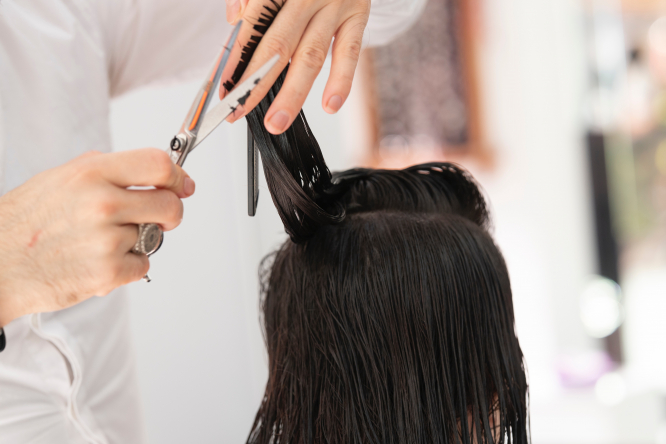

In [173]:
tok1 = os.getenv("tok1")
tok2 = os.getenv("tok2")
url_query = 'https://api.foursquare.com/v2/venues/explore' 

params = {"client_id" : tok1,
              "client_secret" : tok2,
              "v": "20180323",
              "ll": f"40.72523, -73.99221",
              "query": "Hairdresser",
              "limit": 25,
              "radius": 7500 
         }
resp = requests.get(url=url_query, params=params)
nidata = json.loads(resp.text)

In [174]:
nidata.keys()

dict_keys(['meta', 'response'])

In [175]:
decoding_data = nidata.get("response")

In [176]:
decoded = decoding_data.get("groups")[0]

In [177]:
hdr = decoded.get("items")

In [178]:
mapani_nombre = ["venue","name"]
mapani_latitud = ["venue","location","lat"]
mapani_longitud = ["venue","location","lng"]

In [179]:
print(getFromDict(nic[0],mapani_nombre))
print(getFromDict(nic[0],mapani_latitud))
print(getFromDict(nic[0],mapani_longitud))

Bumble & Bumble
40.740808060785625
-74.00659656331318


In [180]:
hairdresser = []
for dic in hdr:
    hd = {}
    hd["name"] = getFromDict(dic,mapani_nombre)
    hd["latitud"] = getFromDict(dic,mapani_latitud)
    hd["longitud"] = getFromDict(dic,mapani_longitud)
    hairdresser.append(hd)

In [181]:
hairdresser[0]

{'name': 'Bumble & Bumble',
 'latitud': 40.740808060785625,
 'longitud': -74.00659656331318}

In [182]:
df_hd = pd.DataFrame(hairdresser)
df_hd.head()


,name,latitud,longitud
0,Bumble & Bumble,40.740808,-74.006597
1,Salon 87,40.716131,-73.944494
2,Hair Bar NYC,40.743440,-73.980098
3,Salon Ziba,40.763728,-73.976629
4,Luxe Den Salon & Spa,40.753192,-73.992801


In [183]:
gdf3 = gpd.GeoDataFrame(df_hd, geometry = gpd.points_from_xy(df_hd.longitud,df_hd.latitud))
gdf3.head()

,name,latitud,longitud,geometry
0,Bumble & Bumble,40.740808,-74.006597,POINT (-74.00660 40.74081)
1,Salon 87,40.716131,-73.944494,POINT (-73.94449 40.71613)
2,Hair Bar NYC,40.743440,-73.980098,POINT (-73.98010 40.74344)
3,Salon Ziba,40.763728,-73.976629,POINT (-73.97663 40.76373)
4,Luxe Den Salon & Spa,40.753192,-73.992801,POINT (-73.99280 40.75319)


In [184]:
Map(Layer(gdf3, popup_hover = [popup_element("name","Hairdresser")]))

### Closest hairdresser?

In [185]:
gdf3['geometry']=gdf3['geometry'].apply(lambda x:shapely.geometry.mapping(x))
gdf3

/home/pablofdezc/.local/lib/python3.8/site-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


,name,latitud,longitud,geometry
0,Bumble & Bumble,40.740808,-74.006597,"{'type': 'Point', 'coordinates': (-74.00659656..."
1,Salon 87,40.716131,-73.944494,"{'type': 'Point', 'coordinates': (-73.94449397..."
2,Hair Bar NYC,40.743440,-73.980098,"{'type': 'Point', 'coordinates': (-73.98009789..."
3,Salon Ziba,40.763728,-73.976629,"{'type': 'Point', 'coordinates': (-73.976629, ..."
4,Luxe Den Salon & Spa,40.753192,-73.992801,"{'type': 'Point', 'coordinates': (-73.99280111..."
5,Elite Unisex Salon and Barber Shop,40.783032,-73.948402,"{'type': 'Point', 'coordinates': (-73.94840210..."
6,Hoshi Coupe II,40.729886,-73.988700,"{'type': 'Point', 'coordinates': (-73.98869993..."
7,Natura Salon and Spa,40.759372,-73.918740,"{'type': 'Point', 'coordinates': (-73.91874023..."
8,Spiotta Salon,40.753892,-73.989495,"{'type': 'Point', 'coordinates': (-73.98949450..."
9,Leonardo Rossi Salon Studio,40.742840,-73.996910,"{'type': 'Point', 'coordinates': (-73.99691, 4..."


In [71]:
db = client.Ironhack
collection = db.hairdresser
collection.create_index ([("geometry", GEOSPHERE)])

'geometry_2dsphere'

In [72]:
data = gdf3.to_dict(orient='records')
collection.insert_many(data)

In [73]:
data[:5]

[{'name': 'Bumble & Bumble',
  'latitud': 40.740808060785625,
  'longitud': -74.00659656331318,
  'geometry': {'type': 'Point',
   'coordinates': (-74.00659656331318, 40.740808060785625)},
  '_id': ObjectId('6079c336b93d5c8a1ae4312b')},
 {'name': 'Salon 87',
  'latitud': 40.7161311528166,
  'longitud': -73.94449397921562,
  'geometry': {'type': 'Point',
   'coordinates': (-73.94449397921562, 40.7161311528166)},
  '_id': ObjectId('6079c336b93d5c8a1ae4312c')},
 {'name': 'Hair Bar NYC',
  'latitud': 40.7434395,
  'longitud': -73.98009789999999,
  'geometry': {'type': 'Point',
   'coordinates': (-73.98009789999999, 40.7434395)},
  '_id': ObjectId('6079c336b93d5c8a1ae4312d')},
 {'name': 'Luxe Den Salon & Spa',
  'latitud': 40.75319205493974,
  'longitud': -73.99280111042323,
  'geometry': {'type': 'Point',
   'coordinates': (-73.99280111042323, 40.75319205493974)},
  '_id': ObjectId('6079c336b93d5c8a1ae4312e')},
 {'name': 'Salon Ziba',
  'latitud': 40.7637279,
  'longitud': -73.976629,
  'g

In [74]:
cercano3 = db.hairdresser.find({"geometry":{"$near":{"type":"Point", "coordinates":[40.72523, -73.99221]}}})
list(cercano3)[:5]

[{'_id': ObjectId('6079c336b93d5c8a1ae4313a'),
  'name': 'Sena African Hair Braiding',
  'latitud': 40.683109283447266,
  'longitud': -73.97730255126953,
  'geometry': {'type': 'Point',
   'coordinates': [-73.97730255126953, 40.683109283447266]}},
 {'_id': ObjectId('6079c336b93d5c8a1ae4312c'),
  'name': 'Salon 87',
  'latitud': 40.7161311528166,
  'longitud': -73.94449397921562,
  'geometry': {'type': 'Point',
   'coordinates': [-73.94449397921562, 40.7161311528166]}},
 {'_id': ObjectId('6079c336b93d5c8a1ae43137'),
  'name': 'The Blue Stove',
  'latitud': 40.71751232266746,
  'longitud': -73.94490768662774,
  'geometry': {'type': 'Point',
   'coordinates': [-73.94490768662774, 40.71751232266746]}},
 {'_id': ObjectId('6079c336b93d5c8a1ae43135'),
  'name': 'Human@Ease',
  'latitud': 40.723015527116985,
  'longitud': -73.95289572608212,
  'geometry': {'type': 'Point',
   'coordinates': [-73.95289572608212, 40.723015527116985]}},
 {'_id': ObjectId('6079c336b93d5c8a1ae43136'),
  'name': 'Bi

## Starbucks

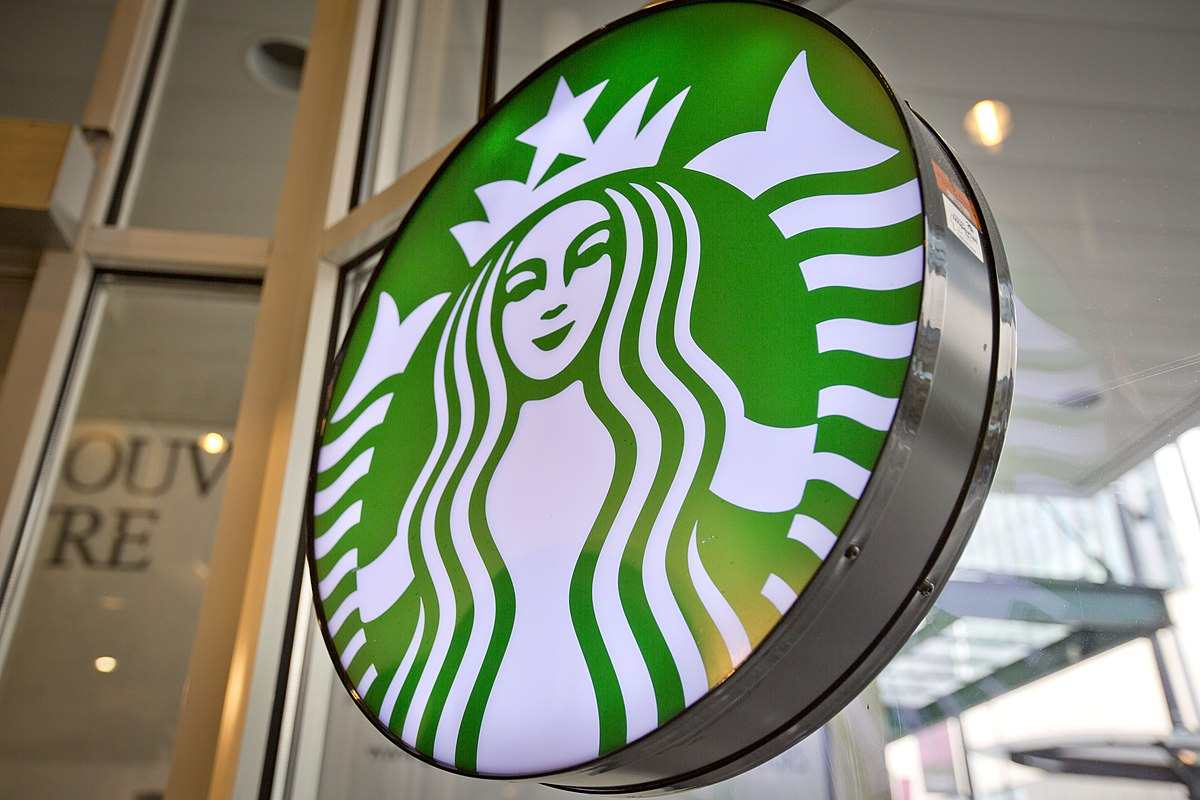

In [85]:
params = {"client_id" : tok1,
              "client_secret" : tok2,
              "v": "20180323",
              "ll": f"40.72523, -73.99221",
              "query": "Starbucks",
              "limit": 10,
              "radius": 500
         }
resp = requests.get(url=url, params=params)
strdata = json.loads(resp.text)

In [86]:
strdata.keys()

dict_keys(['meta', 'response'])

In [87]:
decoding_data = strdata.get("response")

In [88]:
decoded = decoding_data.get("groups")[0]

In [89]:
star = decoded.get("items")

In [90]:
mapastar_nombre = ["venue","name"]
mapastar_latitud = ["venue","location","lat"]
mapastar_longitud = ["venue","location","lng"]

In [91]:
print(getFromDict(star[0],mapastar_nombre))
print(getFromDict(star[0],mapastar_latitud))
print(getFromDict(star[0],mapastar_longitud))

Starbucks Reserve
40.72994333023035
-73.9939131949986


In [92]:
starbucks = []
for dic in star:
    st = {}
    st["name"] = getFromDict(dic,mapastar_nombre)
    st["latitud"] = getFromDict(dic,mapastar_latitud)
    st["longitud"] = getFromDict(dic,mapastar_longitud)
    starbucks.append(st)

In [93]:
starbucks[0]

{'name': 'Starbucks Reserve',
 'latitud': 40.72994333023035,
 'longitud': -73.9939131949986}

In [95]:
df_st = pd.DataFrame(starbucks)
df_st.head()

,name,latitud,longitud
0,Starbucks Reserve,40.729943,-73.993913
1,Starbucks,40.730461,-73.990782
2,Starbucks,40.727192,-73.995460
3,Starbucks,40.724492,-73.987715
4,Starbucks,40.729908,-73.991407


In [96]:
gdf4 = gpd.GeoDataFrame(df_st, geometry = gpd.points_from_xy(df_st.longitud,df_st.latitud))
gdf4.head()

,name,latitud,longitud,geometry
0,Starbucks Reserve,40.729943,-73.993913,POINT (-73.99391 40.72994)
1,Starbucks,40.730461,-73.990782,POINT (-73.99078 40.73046)
2,Starbucks,40.727192,-73.995460,POINT (-73.99546 40.72719)
3,Starbucks,40.724492,-73.987715,POINT (-73.98771 40.72449)
4,Starbucks,40.729908,-73.991407,POINT (-73.99141 40.72991)


In [97]:
Map(Layer(gdf4, popup_hover = [popup_element("name","Starbucks")]))

### Closest Starbucks?

In [98]:

gdf4['geometry']=gdf4['geometry'].apply(lambda x:shapely.geometry.mapping(x))
gdf4

/home/pablofdezc/.local/lib/python3.8/site-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


,name,latitud,longitud,geometry
0,Starbucks Reserve,40.729943,-73.993913,"{'type': 'Point', 'coordinates': (-73.99391319..."
1,Starbucks,40.730461,-73.990782,"{'type': 'Point', 'coordinates': (-73.99078218..."
2,Starbucks,40.727192,-73.995460,"{'type': 'Point', 'coordinates': (-73.99546, 4..."
3,Starbucks,40.724492,-73.987715,"{'type': 'Point', 'coordinates': (-73.98771484..."
4,Starbucks,40.729908,-73.991407,"{'type': 'Point', 'coordinates': (-73.99140743..."
5,Starbucks,40.722585,-73.998023,"{'type': 'Point', 'coordinates': (-73.99802280..."
6,Starbucks,40.726890,-74.000260,"{'type': 'Point', 'coordinates': (-74.00026, 4..."
7,Starbucks,40.719252,-73.990045,"{'type': 'Point', 'coordinates': (-73.99004522..."
8,Starbucks,40.720779,-74.004356,"{'type': 'Point', 'coordinates': (-74.00435638..."
9,Starbucks,40.733033,-73.999677,"{'type': 'Point', 'coordinates': (-73.999677, ..."


In [99]:
db = client.Ironhack
collection = db.starbucks
collection.create_index ([("geometry", GEOSPHERE)])

'geometry_2dsphere'

In [100]:
data = gdf4.to_dict(orient='records')
collection.insert_many(data)

In [101]:
data[:5]

[{'name': 'Starbucks Reserve',
  'latitud': 40.72994333023035,
  'longitud': -73.9939131949986,
  'geometry': {'type': 'Point',
   'coordinates': (-73.9939131949986, 40.72994333023035)},
  '_id': ObjectId('6079c7c0b93d5c8a1ae4315f')},
 {'name': 'Starbucks',
  'latitud': 40.73046083792656,
  'longitud': -73.99078218925392,
  'geometry': {'type': 'Point',
   'coordinates': (-73.99078218925392, 40.73046083792656)},
  '_id': ObjectId('6079c7c0b93d5c8a1ae43160')},
 {'name': 'Starbucks',
  'latitud': 40.727192,
  'longitud': -73.99546,
  'geometry': {'type': 'Point', 'coordinates': (-73.99546, 40.727192)},
  '_id': ObjectId('6079c7c0b93d5c8a1ae43161')},
 {'name': 'Starbucks',
  'latitud': 40.72449233,
  'longitud': -73.98771484,
  'geometry': {'type': 'Point', 'coordinates': (-73.98771484, 40.72449233)},
  '_id': ObjectId('6079c7c0b93d5c8a1ae43162')},
 {'name': 'Starbucks',
  'latitud': 40.72990798225845,
  'longitud': -73.99140743961189,
  'geometry': {'type': 'Point',
   'coordinates': (-7

In [103]:
cercano4 = db.starbucks.find({"geometry":{"$near":{"type":"Point", "coordinates":[40.72523, -73.99221]}}})
list(cercano4)[:5]

[{'_id': ObjectId('6079c7c0b93d5c8a1ae43166'),
  'name': 'Starbucks',
  'latitud': 40.71925187,
  'longitud': -73.99004522,
  'geometry': {'type': 'Point', 'coordinates': [-73.99004522, 40.71925187]}},
 {'_id': ObjectId('6079c7c0b93d5c8a1ae43162'),
  'name': 'Starbucks',
  'latitud': 40.72449233,
  'longitud': -73.98771484,
  'geometry': {'type': 'Point', 'coordinates': [-73.98771484, 40.72449233]}},
 {'_id': ObjectId('6079c7c0b93d5c8a1ae43164'),
  'name': 'Starbucks',
  'latitud': 40.722584953691005,
  'longitud': -73.9980228047693,
  'geometry': {'type': 'Point',
   'coordinates': [-73.9980228047693, 40.722584953691005]}},
 {'_id': ObjectId('6079c7c0b93d5c8a1ae43167'),
  'name': 'Starbucks',
  'latitud': 40.72077941894531,
  'longitud': -74.00435638427734,
  'geometry': {'type': 'Point',
   'coordinates': [-74.00435638427734, 40.72077941894531]}},
 {'_id': ObjectId('6079c7c0b93d5c8a1ae43161'),
  'name': 'Starbucks',
  'latitud': 40.727192,
  'longitud': -73.99546,
  'geometry': {'typ

## Nightclub

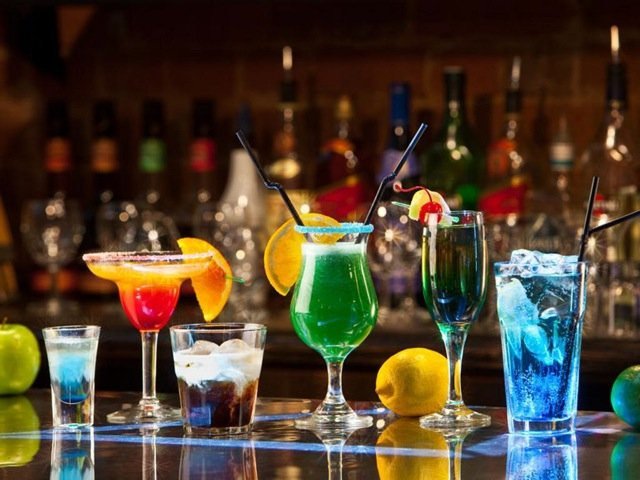

In [104]:
params = {"client_id" : tok1,
              "client_secret" : tok2,
              "v": "20180323",
              "ll": f"40.72523, -73.99221",
              "query": "Nightclub",
              "limit": 20,
              "radius": 2000
         }
resp = requests.get(url=url, params=params)
vegdata = json.loads(resp.text)

In [105]:
decoding_data = vegdata.get("response")

In [106]:
decoded = decoding_data.get("groups")[0]

In [107]:
nightclub = decoded.get("items")

In [112]:
mapanight_nombre = ["venue","name"]
mapanight_latitud = ["venue","location","lat"]
mapanight_longitud = ["venue","location","lng"]

In [113]:
print(getFromDict(nightclub[0],mapanight_nombre))
print(getFromDict(nightclub[0],mapanight_latitud))
print(getFromDict(nightclub[0],mapanight_longitud))

The Box
40.72183514522036
-73.99200009718089


In [115]:
nightclubs = []
for dic in nightclub:
    nc = {}
    nc["name"] = getFromDict(dic,mapanight_nombre)
    nc["latitud"] = getFromDict(dic,mapanight_latitud)
    nc["longitud"] = getFromDict(dic,mapanight_longitud)
    nightclubs.append(nc)

In [116]:
nightclubs[0]

{'name': 'The Box',
 'latitud': 40.72183514522036,
 'longitud': -73.99200009718089}

In [117]:
df_nc = pd.DataFrame(nightclubs)
df_nc.head()

,name,latitud,longitud
0,The Box,40.721835,-73.992000
1,Paul's Cocktail Lounge,40.719563,-74.005035
2,Element,40.722126,-73.986619
3,The Blond,40.719242,-74.000066
4,Public Arts,40.722948,-73.991726


In [118]:
gdf5 = gpd.GeoDataFrame(df_nc, geometry = gpd.points_from_xy(df_nc.longitud,df_nc.latitud))
gdf5.head()

,name,latitud,longitud,geometry
0,The Box,40.721835,-73.992000,POINT (-73.99200 40.72184)
1,Paul's Cocktail Lounge,40.719563,-74.005035,POINT (-74.00504 40.71956)
2,Element,40.722126,-73.986619,POINT (-73.98662 40.72213)
3,The Blond,40.719242,-74.000066,POINT (-74.00007 40.71924)
4,Public Arts,40.722948,-73.991726,POINT (-73.99173 40.72295)


In [120]:
Map(Layer(gdf5, popup_hover = [popup_element("name","Nightclubs")]))

### Closest nightclub?

In [121]:

gdf5['geometry']=gdf5['geometry'].apply(lambda x:shapely.geometry.mapping(x))
gdf5

/home/pablofdezc/.local/lib/python3.8/site-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


,name,latitud,longitud,geometry
0,The Box,40.721835,-73.992000,"{'type': 'Point', 'coordinates': (-73.99200009..."
1,Paul's Cocktail Lounge,40.719563,-74.005035,"{'type': 'Point', 'coordinates': (-74.00503511..."
2,Element,40.722126,-73.986619,"{'type': 'Point', 'coordinates': (-73.98661946..."
3,The Blond,40.719242,-74.000066,"{'type': 'Point', 'coordinates': (-74.00006632..."
4,Public Arts,40.722948,-73.991726,"{'type': 'Point', 'coordinates': (-73.99172649..."
5,Nublu,40.722589,-73.979888,"{'type': 'Point', 'coordinates': (-73.97988760..."
6,Nublu 151,40.725606,-73.977978,"{'type': 'Point', 'coordinates': (-73.97797824..."
7,Paradise Garage,40.727947,-74.006250,"{'type': 'Point', 'coordinates': (-74.00625001..."
8,Bedlam,40.721866,-73.980485,"{'type': 'Point', 'coordinates': (-73.98048518..."
9,S.O.B.'s,40.728491,-74.005287,"{'type': 'Point', 'coordinates': (-74.00528683..."


In [123]:
db = client.Ironhack
collection = db.nightclubs
collection.create_index ([("geometry", GEOSPHERE)])

'geometry_2dsphere'

In [124]:
data = gdf5.to_dict(orient='records')
collection.insert_many(data)

In [125]:
data[:5]

[{'name': 'The Box',
  'latitud': 40.72183514522036,
  'longitud': -73.99200009718089,
  'geometry': {'type': 'Point',
   'coordinates': (-73.99200009718089, 40.72183514522036)},
  '_id': ObjectId('6079c925b93d5c8a1ae43169')},
 {'name': "Paul's Cocktail Lounge",
  'latitud': 40.719562606558206,
  'longitud': -74.005035117036,
  'geometry': {'type': 'Point',
   'coordinates': (-74.005035117036, 40.719562606558206)},
  '_id': ObjectId('6079c925b93d5c8a1ae4316a')},
 {'name': 'Element',
  'latitud': 40.722125792186446,
  'longitud': -73.98661946179388,
  'geometry': {'type': 'Point',
   'coordinates': (-73.98661946179388, 40.722125792186446)},
  '_id': ObjectId('6079c925b93d5c8a1ae4316b')},
 {'name': 'The Blond',
  'latitud': 40.71924234753701,
  'longitud': -74.00006632090165,
  'geometry': {'type': 'Point',
   'coordinates': (-74.00006632090165, 40.71924234753701)},
  '_id': ObjectId('6079c925b93d5c8a1ae4316c')},
 {'name': 'Public Arts',
  'latitud': 40.72294781563586,
  'longitud': -73.

In [126]:
cercano5 = db.nightclubs.find({"geometry":{"$near":{"type":"Point", "coordinates":[40.72523, -73.99221]}}})
list(cercano5)[:5]

[{'_id': ObjectId('6079c925b93d5c8a1ae43171'),
  'name': 'Bedlam',
  'latitud': 40.72186578600761,
  'longitud': -73.98048518308426,
  'geometry': {'type': 'Point',
   'coordinates': [-73.98048518308426, 40.72186578600761]}},
 {'_id': ObjectId('6079c925b93d5c8a1ae43174'),
  'name': 'Mehanata Bulgarian Bar',
  'latitud': 40.71945037628919,
  'longitud': -73.98880761858857,
  'geometry': {'type': 'Point',
   'coordinates': [-73.98880761858857, 40.71945037628919]}},
 {'_id': ObjectId('6079c925b93d5c8a1ae43175'),
  'name': 'Sons of Essex',
  'latitud': 40.72013850256988,
  'longitud': -73.98744301700677,
  'geometry': {'type': 'Point',
   'coordinates': [-73.98744301700677, 40.72013850256988]}},
 {'_id': ObjectId('6079c925b93d5c8a1ae4316e'),
  'name': 'Nublu',
  'latitud': 40.72258949330302,
  'longitud': -73.97988760008674,
  'geometry': {'type': 'Point',
   'coordinates': [-73.97988760008674, 40.72258949330302]}},
 {'_id': ObjectId('6079c925b93d5c8a1ae43176'),
  'name': 'Home Sweet Home'